In [6]:
import pandas as pd
import pyarrow.feather as feather
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [7]:
train = feather.read_feather('/Volumes/Elements HD/Data Sets/Amex/archive/train_data.ftr')
train_labels = pd.read_csv('/Volumes/Elements HD/Data Sets/Amex/train_labels.csv')

FileNotFoundError: [Errno 2] Failed to open local file '/Volumes/Elements HD/Data Sets/Amex/archive/train_data.ftr'. Detail: [errno 2] No such file or directory

In [ ]:
train.head(5)


In [ ]:
train.shape

In [ ]:
train_labels.head(5)

#### The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:\

D_* = Delinquency variables\
S_* = Spend variables\
P_* = Payment variables\
B_* = Balance variables\
R_* = Risk variables

In [5]:
target_class = pd.DataFrame({
    'count': train['target'].value_counts(), 
    'Percentage': train['target'].value_counts(normalize=True) * 100
})


In [6]:
target_class

,count,Percentage
target,,
0,4153582,75.090279
1,1377869,24.909721


In [7]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [8]:
fea_D = [d for d in train.columns if d.startswith('D_')]
fea_S = [s for s in train.columns if s.startswith('S_')]
fea_P = [p for p in train.columns if p.startswith('P_')]
fea_B = [b for b in train.columns if b.startswith('B_')]
fea_R = [r for r in train.columns if r.startswith('R_')]
print(f'Total number of Delinquency variables: {len(fea_D)}')
print(f'Total number of Spend variables: {len(fea_S)}')
print(f'Total number of Payment variables: {len(fea_P)}')
print(f'Total number of Balance variables: {len(fea_B)}')
print(f'Total number of Risk variables: {len(fea_R)}')

Total number of Delinquency variables: 96
Total number of Spend variables: 22
Total number of Payment variables: 3
Total number of Balance variables: 40
Total number of Risk variables: 28


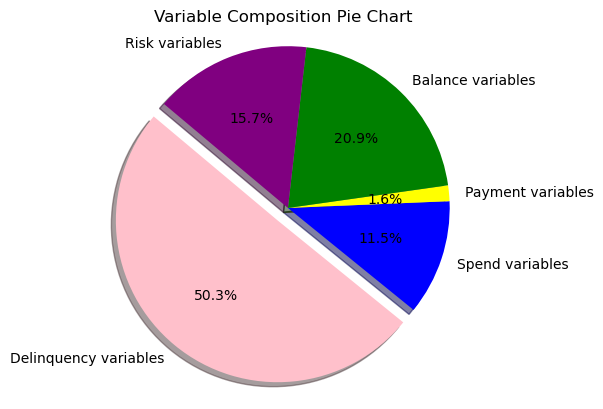

In [9]:
labels = 'Delinquency variables','Spend variables','Payment variables', 'Balance variables', 'Risk variables'
sized = len(fea_D)/len(train.columns)
sizes = len(fea_S)/len(train.columns)
sizep = len(fea_P)/len(train.columns)
sizeb = len(fea_B)/len(train.columns)
sizer = 1 - sized - sizes - sizep - sizeb

sizeq = [sized,sizes,sizep,sizeb,sizer]  # Percentages of each segment
colors = ['Pink', 'Blue', 'Yellow', 'Green', 'Purple']
explode = (0.1, 0,0,0,0)  # explode 1st slice

# Plot
plt.pie(sizeq, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Variable Composition Pie Chart')
plt.show()

In [10]:
print(train['S_2'].min(), train['S_2'].max())

2017-03-01 00:00:00 2018-03-31 00:00:00


In [11]:
train.isna().sum()

customer_ID          0
S_2                  0
P_2              45985
D_39                 0
B_1                  0
                ...   
D_142          4587043
D_143           101548
D_144            40727
D_145           101548
target               0
Length: 191, dtype: int64

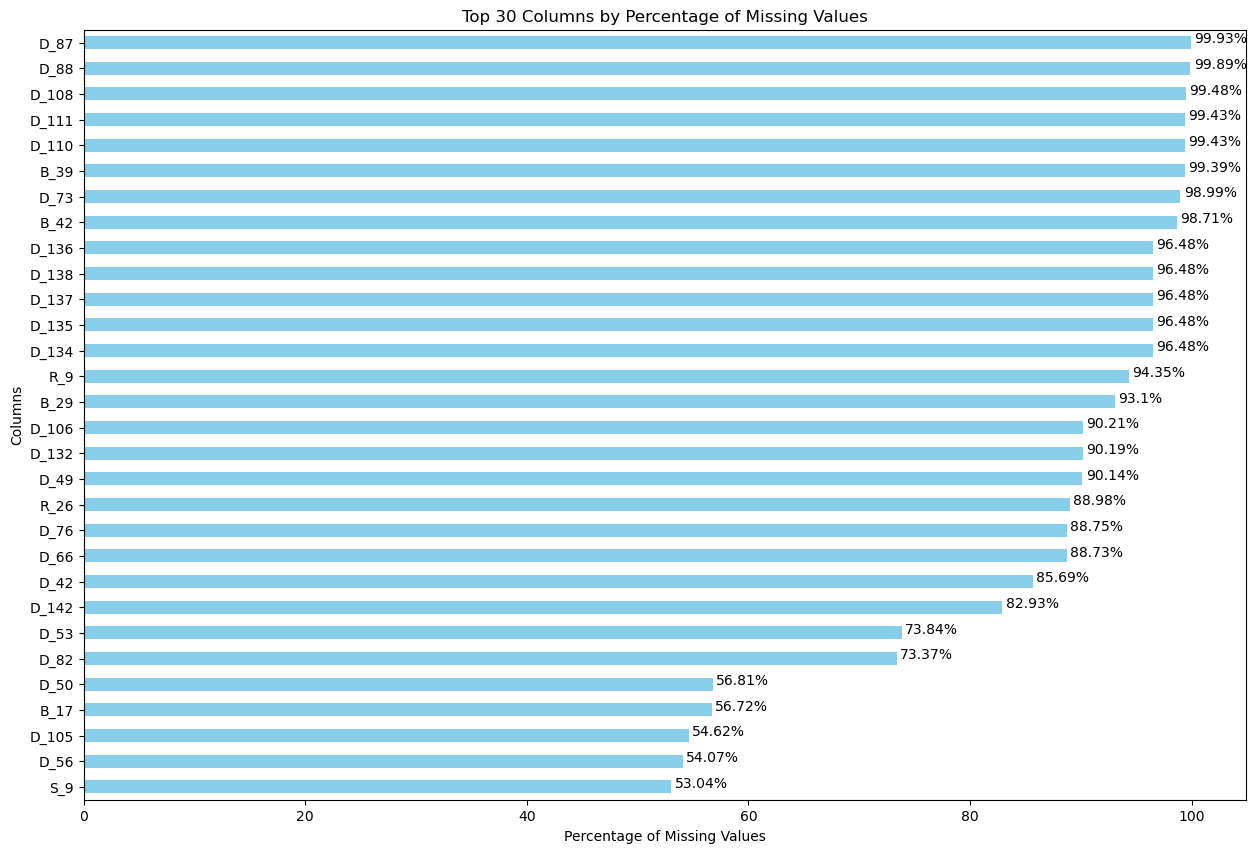

In [12]:
# Calculate the percentage of missing values for each column
missing_percent = (train.isna().sum() / len(train)) * 100

# Sort the values in descending order and select the top 30
missing_percent = missing_percent.sort_values(ascending=False).head(30)

# Create a horizontal bar chart for the top 30 columns
plt.figure(figsize=(15, 10))
ax = missing_percent.plot(kind='barh', color='skyblue')
for i in ax.patches:
    plt.text(i.get_width() + 0.3, i.get_y() + 0.1, str(round((i.get_width()), 2)) + '%', va='center')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Columns')
plt.title('Top 30 Columns by Percentage of Missing Values')
plt.gca().invert_yaxis()  # To display the highest percentage at the top
plt.show()


In [13]:
num_features = train.columns.difference(cat_features)
num_features

Index(['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17',
       'B_18',
       ...
       'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'customer_ID',
       'target'],
      dtype='object', length=180)

In [14]:
num_features = num_features.drop(labels = ['D_87', 'D_88', 'D_110', 'D_108', 'D_111', 'B_39', 'B_42', 'D_73', 'target', 'customer_ID', 'S_2'])
print(num_features)
# num_features

Index(['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17',
       'B_18',
       ...
       'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8',
       'S_9'],
      dtype='object', length=169)


#### Principal Component Analysis

In [15]:
train_nf = train[num_features].apply(pd.to_numeric, errors='coerce')

In [16]:
train_nf = train[num_features].fillna(0) 

In [17]:
print(train_nf.dtypes)

B_1     float16
B_10    float16
B_11    float16
B_12    float16
B_13    float16
         ...   
S_5     float16
S_6     float16
S_7     float16
S_8     float16
S_9     float16
Length: 169, dtype: object


In [ ]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_nf[num_features])

pca = PCA()
pca_features = pca.fit_transform(train_scaled)
